# <span style="color:#ff1414"> BEDtools analysis. </span>

This is a script to answer research questions outlined elsewhere. In summary, this script:

1. compares methylation results between different methylation-callers, and between different methylation sequencing methods.

2. compares methylation between genes and non-gene regions

3. compares methylation between transposons and non-repetitive regions

4. compares transposons and genes


Note:
- PB/pb = PacBio
- ONT/ont = Oxford Nanopore Technology
- NP = Nanopolish

In [862]:
import pybedtools
from pybedtools import BedTool
import os
import glob
import pprint
#import numpy # need for p-value stats
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib_venn import venn2
from scipy.stats import chisquare
from scipy.stats import spearmanr

In [430]:
#First we need to define the base dirs
DIRS ={}
DIRS['BASE1'] = '/home/anjuni/methylation_calling/pacbio'
DIRS['BASE2'] = '/home/anjuni/analysis'
DIRS['BED_INPUT'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'sequencing_comparison')
DIRS['GFF_INPUT'] = os.path.join(DIRS['BASE2'], 'gff_output')
DIRS['WINDOW_OUTPUT'] = os.path.join(DIRS['BASE2'], 'windows')
DIRS['WINDOW_INPUT'] = os.path.join(DIRS['BASE2'], 'input_for_windows')
DIRS['REF'] = '/home/anjuni/Pst_104_v13_assembly/'
DIRS['TEST_COV'] = os.path.join(DIRS['BASE2'], 'coverage/test_feature_files')

In [438]:
pprint.pprint(DIRS) # add the additional ones below to the cell above maybe?

{'5MC_CUTOFFS': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC',
 '6MA_CUTOFFS': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA',
 'BASE1': '/home/anjuni/methylation_calling/pacbio',
 'BASE2': '/home/anjuni/analysis',
 'BED_CUTOFFS': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs',
 'BED_INPUT': '/home/anjuni/analysis/bedtools_output/sequencing_comparison',
 'FEATURES': '/home/anjuni/analysis/coverage/feature_files',
 'GFF_INPUT': '/home/anjuni/analysis/gff_output',
 'I_FROM_C': '/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs',
 'METHYL': '/home/anjuni/analysis/input_for_windows/methylation_files',
 'REF': '/home/anjuni/Pst_104_v13_assembly/',
 'TEST_COV': '/home/anjuni/analysis/coverage/test_feature_files',
 'WINDOW_INPUT': '/home/anjuni/analysis/input_for_windows',
 'WINDOW_OUTPUT': '/home/anjuni/analysis/windows'}


In [33]:
#Quick chech if directories exist
for value in DIRS.values():
    if not os.path.exists(value):
        print('%s does not exist' % value)

In [34]:
#Make filepaths
bed_file_list = [fn for fn in glob.iglob('%s/*.bed' % DIRS['BED_INPUT'], recursive=True)]
gff_file_list = [fn for fn in glob.iglob('%s/*anno.gff3' % DIRS['GFF_INPUT'], recursive=True)]
te_file_list = [fn for fn in glob.iglob('%s/*.gff' % DIRS['GFF_INPUT'], recursive=True)]

In [35]:
#Check that the list works
print(*bed_file_list, sep='\n')
print(*gff_file_list, sep='\n')
print(*te_file_list, sep='\n')

/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/6mA_pb_ont.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_hc_tombo_sorted.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_np_tombo.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/6mA_ont_pb.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_np_tombo.bed
/home/anjuni/analysis/gff_output/Pst_104E_v13_p_ctg_combined_sorted_anno.gff3
/home/anjuni/analysis/gff_output/Pst_104E_v13_h_ctg_combined_sorted_anno.gff3
/home/anjuni/analysis/gff_output/Pst_104E_v13_h_ctg.REPET.sorted.filtered.superfamily.gff
/home/anjuni/analysis/gff_output/Pst_104E_v13_p_ctg.REPET.sorted.filtered.superfamily.gff
/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.gff


## <span style='color:deeppink'> 1. Comparing methylation sequencing methods <span/>

In [8]:
%%bash

# find overlap between 6mA from PacBio and Nanopore for 6mA data

pb=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed # use basecall accuracy instead of Phred score
ont=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed # use sites with non-zero methylation

out1=/home/anjuni/analysis/bedtools_output/sequencing_comparison/6mA_pb_ont.bed
out2=/home/anjuni/analysis/bedtools_output/sequencing_comparison/6mA_ont_pb.bed

echo $pb
echo $ont

bedtools intersect -a $pb -b $ont > $out1
bedtools intersect -a $ont -b $pb > $out2

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed


In [12]:
%%bash

#check how many overlapping sites there were

cd /home/anjuni/analysis/bedtools_output/sequencing_comparison/
echo PacBio sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed | wc -l

echo Overlapping sites:
less 6mA_pb_ont.bed | wc -l

echo Nanopore sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed | wc -l

echo Overlapping sites:
less 6mA_ont_pb.bed | wc -l

echo Total adenine sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_tombo_sorted.bed | wc -l

PacBio sites:
88932
Overlapping sites:
84733
Nanopore sites:
83451878
Overlapping sites:
84733
Total adenine sites:
85779879


In [362]:
# Descriptive Statistics

print('Percentage overlap between PacBio and Nanopore as a proportion of PB sites:', "{0:.3f}%".format(100*84733/88932))
# overlap between pb and ont, divided by total PacBio sites

print('Percentage overlap between PacBio and Nanopore as a proportation of ONT sites:', "{0:.3f}%".format(100*84733/83451878))
# = overlap between pb and ont, divided by total Nanopore sites

print('Percentage adenine methylation from overlap:', "{0:.3f}%".format(100*84733/85779879))
# = overlapping sites, divided by total number of adenines (gained from number of lines on tombo file. tombo counts all adenines)

Percentage overlap between PacBio and Nanopore as a proportion of PB sites: 95.278%
Percentage overlap between PacBio and Nanopore as a proportation of ONT sites: 0.102%
Percentage adenine methylation from overlap: 0.099%


#### <span style='color:deeppink'> Observations <span/>

Very high similarity between Nanopore and PacBio, when compared to PacBio. But PacBio sites are only a small fraction of Tombo sites, and only include highly accurate sites.

When overlapping PacBio and all Nanopore (Tombo) sites, there was a higher overlap (88932) than when overlapping only non-zero PB and ONT sites (84733). This indicates PB detected sites that Nanopore did not, and these were high probability sites that were missed, as PB only had high probability (>99% basecall accuracy) sites.

There are also more overlapped sites when using the zero-probability sites from tombo, compared to only using only high confidence sites from both. This also suggests that Tombo/Nanopore had missed some methylated sites.

## <span style='color:#ff14ff'> 2. Comparing methylation detection methods <span/>

In [3]:
%%bash

# compare overlap between Tombo and Nanopolish for 5mC data
np=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
tombo=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed

out1=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_np_tombo.bed
out2=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_tombo_np.bed

echo $np
echo $tombo

bedtools intersect -a $np -b $tombo > $out1
bedtools intersect -a $tombo -b $np > $out2

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed


In [370]:
%%bash

#check how many overlapping sites there were

cd /home/anjuni/analysis/bedtools_output/sequencing_comparison/

echo Nanopolish sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed | wc -l

echo Tombo sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed | wc -l

echo Overlapping sites:
less 5mC_np_tombo.bed | wc -l

echo Total cytosine sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_tombo_sorted.bed | wc -l

echo Total CpG sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_nanopolish_sorted.bed | wc -l

Nanopolish sites:
3783438
Tombo sites:
67308386
Overlapping sites:
1681653
Total cytosine sites:
68536018
Total CpG sites:
5302131


In [363]:
# Descriptive Statistics

print('Percentage overlap between Nanopolish and Tombo as a proportion of NP sites:', "{0:.3f}%".format(100*1681653/3783438))
# overlap between np and tombo, divided by total NP sites

print('Percentage overlap between Nanopolish and Tombo as a proportation of Tombo sites:', "{0:.3f}%".format(100*1681653/67308386))
# = overlap between np and tombo, divided by total Tombo sites

print('Percentage cytosine methylation from overlap:', "{0:.3f}%".format(100*1681653/68536018))
# = overlapping sites, divided by total number of cytosines (gained from number of lines on tombo file. tombo counts all cytosines)

print('Percentage of CpG sites methylated from overlap:', "{0:.3f}%".format(100*1681653/5302131))
# = overlapping sites, divided by total number of CpG sites (gained from number of lines on np file. np counts all cpg sites)

Percentage overlap between Nanopolish and Tombo as a proportion of NP sites: 44.448%
Percentage overlap between Nanopolish and Tombo as a proportation of Tombo sites: 2.498%
Percentage cytosine methylation from overlap: 2.454%
Percentage of CpG sites methylated from overlap: 31.717%


#### <span style='color:#ff14ff'> Observations <span/>
While adenine methylation had high similarity between ONT and PB, cytosine methylation had only 44% similarity between NP and tombo. This is likely because NP only has CpG sites, and Tombo has all cytosine sites, so Tombo will detect far more potentially methylated sites, even those that are not CpG sites, so it will have far more sites than NP to begin with.

### <span style='color:#ff14ff'> 2.A Taking CpG sites into account when comparing methylation detection methods <span/>

In [24]:
%%bash

#check how many cytosine sites and CpG sites there are

cd /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/

echo CpG sites:
less 5mC_nanopolish_sorted.bed | wc -l

echo Cytosine sites:
less 5mC_tombo_sorted.bed | wc -l

CpG sites:
5302131
Cytosine sites:
68536018


In [364]:
# Descriptive Statistics

print('Percentage of CpG sites as a proportion of cytosine sites:', "{0:.3f}%".format(100*5302131/68536018))
# np sites divided by tombo sites

Percentage of CpG sites as a proportion of cytosine sites: 7.736%


#### <span style='color:#ff14ff'> Solution <span/>
1. Make a file of methylated CpG sites detected by Tombo.
2. Intersect this with methylated (CpG) sites detected by Nanopolish.

I will be overlapping CpG sites from Tombo and NP, because NP only has CpG sites and Tombo has all cytosine sites.
So from the start, the overlap wouldn't have been accurate, because tombo considers sites that NP does not.

#### <span style='color:#ff14ff'> CpG Sites <span/>

In [160]:
%%bash

# make a file of CpG sites from tombo
all_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_nanopolish_sorted.bed
all_tombo=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed
tombo_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed

bedtools intersect -a $all_tombo -b $all_cpg > $tombo_cpg

In [161]:
%%bash

# intersect Tombo and NP CpG sites
tombo_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed
np_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
m_tombo_cpg=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_tombo_np.bed
m_np_cpg=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_np_tombo.bed

bedtools intersect -a $tombo_cpg -b $np_cpg > $m_tombo_cpg
bedtools intersect -a $np_cpg -b $tombo_cpg > $m_np_cpg

In [369]:
%%bash

#check how many overlapping sites there were
cd /home/anjuni/analysis/bedtools_output/sequencing_comparison/

echo Nanopolish methylated CpG sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed | wc -l

echo Tombo methylated CpG sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed | wc -l

echo Overlapping methylated CpG sites:
less 5mC_CpG_tombo_np.bed | wc -l

echo Total CpG sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_nanopolish_sorted.bed | wc -l

Nanopolish methylated CpG sites:
3783438
Tombo methylated CpG sites:
5167951
Overlapping methylated CpG sites:
3708640
Total CpG sites:
5302131


In [371]:
# Descriptive Statistics

print('Percentage overlap between Nanopolish and Tombo as a proportion of NP CpG sites:', "{0:.3f}%".format(100*1681653/3783438))
# overlap between np and tombo, divided by total NP CpG sites

print('Percentage overlap between Nanopolish and Tombo as a proportation of Tombo CpG sites:', "{0:.3f}%".format(100*1681653/5167951))
# = overlap between np and tombo, divided by total Tombo CpG sites

print('Percentage of CpG sites methylated:', "{0:.3f}%".format(100*1681653/5302131))
# = overlapping sites, divided by total number of CpG sites (gained from number of lines on np file. np counts all cpg sites)

Percentage overlap between Nanopolish and Tombo as a proportion of NP CpG sites: 44.448%
Percentage overlap between Nanopolish and Tombo as a proportation of Tombo CpG sites: 32.540%
Percentage of CpG sites methylated: 31.717%


#### <span style='color:#ff14ff'> Observations <span/>
While the overlap between Tombo and NP didn't change after only comparing CpG sites, the nearly 50% overlap may be because NP only considers one strand while Tomb considers both.

This may be resolved by using only the plus file from Tombo and comparing its results to NP.

### <span style='color:#ff14ff'> 2.B Test out whether Nanopolish only detects (+) strand <span/>
Intersect tombo 5mC (-) strand file with nanopolish file to see if there is overlap. Then intersect the tombo (+) strand with nanopolish.

The 44% match may just be because I, for some reason, put all the nanopolish sites as (+) strand when making the original BED file :P

In [147]:
%%bash

#Sort the initial tombo bed files, because they were not sorted and slowed down the intersection

tombo_minus=/home/anjuni/methylation_calling/pacbio/input/bed_files/initial_bed_files/5mC_minus_tombo.bed
tombo_plus=/home/anjuni/methylation_calling/pacbio/input/bed_files/initial_bed_files/5mC_plus_tombo.bed
nanopolish=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_s_nanopolish.bed

sort_tombo_minus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_minus_tombo_sorted.bed
sort_tombo_plus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_plus_tombo_sorted.bed

sortBed -i $tombo_minus > $sort_tombo_minus
sortBed -i $tombo_plus > $sort_tombo_plus

In [148]:
%%bash

#Intersect the (+) and (-) BED files with nanopolish file
#to see whether Nanopolish has methylation-calls on both strands :)

sort_tombo_minus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_minus_tombo_sorted.bed
sort_tombo_plus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_plus_tombo_sorted.bed
nanopolish=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_s_nanopolish.bed

intersectBed -a $nanopolish -b $sort_tombo_minus > /home/anjuni/methylation_calling/pacbio/input/bed_files/nano_minus_tombo_overlap.bed
intersectBed -a $nanopolish -b $sort_tombo_plus > /home/anjuni/methylation_calling/pacbio/input/bed_files/nano_plus_tombo_overlap.bed

In [150]:
%%bash

#Compare the number of NP sites to Tombo sites on the forward and reverse strand
cd /home/anjuni/methylation_calling/pacbio/input/bed_files
echo "The number of CpG sites captured by Nanopolish:"
less 5mC_s_nanopolish.bed | wc -l
echo "The number of overlapping sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:"
less nano_plus_tombo_overlap.bed  | wc -l
echo "The number of overlapping sites captured by Nanopolish and by Tombo on the reverse strand of the reference genome:"
less nano_minus_tombo_overlap.bed  | wc -l

The number of sites captured by Nanopolish:
5302131
The number of overlapping sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:
5221309
The number of overlapping sites captured by Nanopolish and by Tombo on the reverse strand of the reference genome:
0


In [372]:
print('Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of NP sites:', "{0:.3f}%".format(100*5221309/5302131))
# overlap between np and tombo, divided by total NP sites

Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of NP sites: 98.476%


There is a 98% similarity between Nanopolish sites and Tombo forward strand sites, but no similarity between Nanopolish sites and Tombo reverse strand sites, indicating that the 44% similarity between Nanopolish and Tombo from earlier was because Nanopolish only detected methylation on the forward strand.

I am currently re-running Nanopolish methylation-calling in case there was a mistake in the code earlier, causing it to ignore the reverse strand. Re-running the test run for pcontig_109 showed no difference in output to the previous one. They had the same number of sites (46801) and had the same output for the first 10 lines and last 10 lines. Now I think there wasn't a mistake because I only copied the index files to a new folder to save them back to the output folder, while a copy of all index files remained in the original fastq folder. This allowed methylation-calling to continue.

Based on these results, I will intersect the methylated forward strand CpG sites that Tombo detected with the the Nanopolish site, to ensure only related sites intersect :)

In [156]:
%%bash

#bedtools script to check nanopolish results
#if the subtract file is empty, the initial nanopolish run was accurate

nano1=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_s_nanopolish.bed
nano2=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_rerun_s_nanopolish.bed
nano1_2_sub=/home/anjuni/methylation_calling/pacbio/input/bed_files/nanopolish_rerun_subtract.bed

bedtools subtract -a $nano1 -b $nano2 > $nano1_2_sub

In [158]:
!echo "Number of site differences between the original Nanopolish run and the re-run"
!less /home/anjuni/methylation_calling/pacbio/input/bed_files/nanopolish_rerun_subtract.bed | wc -l

Number of site differences between the original Nanopolish run and the re-run
0


As there was no difference in sites between each Nanopolish run, the original run had no issues causing only the (+) strand to be detected and this issue is a result of the software.

### <span style='color:#ff14ff'> 2.C Finding overlap between forward strand CpG Sites <span/>

In [164]:
%%bash

#Make a tombo file with only forward strand CpG to match the Nanopolish data
grep '+' /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed > /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed

#This file ended up being exactly the same as the original CpG file for Tombo, but this new file will be used for added detail

In [165]:
%%bash


# compare overlap between Tombo and Nanopolish for forward strand CpG 5mC data
np=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
tombo=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed

out1=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_np_tombo.bed
out2=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_tombo_np.bed

echo $np
echo $tombo

bedtools intersect -a $np -b $tombo > $out1
bedtools intersect -a $tombo -b $np > $out2

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed


In [374]:
%%bash

#Compare the number of (+) strand CpG NP sites to (+) strand CpG Tombo sites on the forward strand
cd /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files
echo "The number of CpG sites captured by Nanopolish:"
less 5mC_hc_nanopolish_sorted.bed | wc -l
echo "The number of CpG sites captured by Tombo on the forward strand:"
less 5mC_hc_tombo_sorted.CpG.plus.bed | wc -l
echo "The number of overlapping sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:"
less /home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_tombo_np.bed  | wc -l

The number of CpG sites captured by Nanopolish:
3783438
The number of CpG sites captured by Tombo on the forward strand:
5167951
The number of overlapping sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:
3708640


In [375]:
print('Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of NP sites:', "{0:.3f}%".format(100*3708640/3783438))
# overlap between np and tombo, divided by total NP sites
print('Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of Tombo sites:', "{0:.3f}%".format(100*3708640/5167951))
# overlap between np and tombo, divided by total Tombo sites

Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of NP sites: 98.023%
Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of Tombo sites: 71.762%


There was a 98% overlap between Nanopolish and Tombo sites, as a proportion of Nanopolish sites, as this was the smaller dataset. Using the positive strand CpG sites increased the overlap from 44% to 98%.

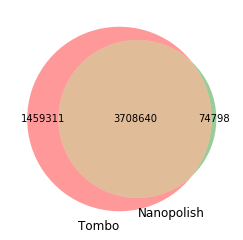

In [384]:
# First way to call the 2 group Venn diagram:
#The number of CpG sites captured by Nanopolish:
#3783438
#The number of CpG sites captured by Tombo on the forward strand:
#5167951
#The number of overlapping sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:
#3708640
c = 3708640
a = 5167951-c
b = 3783438-c
venn2(subsets = (a, b, c), set_labels = ('Tombo', 'Nanopolish'))
plt.show()

In [ ]:
# Nanopore and PacBio Venn diagrams don't look good, so use the tombo nanopolish one,
# and a table of percentages will be used

For the rest of the analysis, I will use the overlapped files for 5mC and 6mA data, and the Tombo files. This is because the Tombo files consider all possible A and C sites in the genome, and provide some consistency between the 6mA and 5mC data. In contrast, Nanopolish only detects 5mC at CpG sites on the forward strand, and SMRTLink does not provide a methylation-call accuracy value that is comparable to the accuracy in Nanopolis and Tombo. While Nanopolish and Tombo use the fraction of reads for the site that are methylated, SMRTLink uses a Phred score to determine methylation-call accuracy.

## <span style='color:#8a14ff'> 3. Making cutoff files. <span/>

### <span style='color:#8a14ff'> 3.A Making cutoff files from five original methylation-calling files, and intersect the two sequencing methods and the two methyaltion-callers. <span/>

In [496]:
# Make the list of cutoffs
cutoff_list = [1.00, 0.99, 0.95, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10, 0.00]

In [497]:
len(cutoff_list)

13

In [196]:
# Define function to filter
def score_filter(feature, L):
    """Returns True if feature is longer than L"""
    return float(feature.score) >= L

def filter_by_cutoffs(bed_files, cutoffs, initial_file_path, final_file_path):
    """Filters files by the list of cutoffs given, and renames the file according to the cutoff."""
    for file in bed_files:
        pybed_object = BedTool(file)
        for x in cutoffs:
            filtered_file = pybed_object.filter(score_filter, x)
            cutoff = "{:.2f}".format(x)
            cutoff_name = '.cutoff.' + cutoff + '.bed'
            out_filename = file.replace('.bed', cutoff_name)
            out_filename = out_filename.replace(initial_file_path, final_file_path)
            filtered_file.saveas(out_filename)

In [ ]:
#Run the function to filter all files
initial_fp = '/home/anjuni/analysis/bedtools_output/sequencing_comparison/'
final_fp = '/home/anjuni/analysis/bedtools_output/cutoffs_from_intersects/'
filter_by_cutoffs(bed_file_list, cutoff_list, initial_fp, final_fp)

In [392]:
# make file handles for the four input files for intersecting, and the hc_tombo file for later analysis
sorted_bed_files = ['/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed']

In [ ]:
#Run the function to make cutoffs of all the sorted bed files
initial_fp1 = '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/'
final_fp1 = '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs/'
filter_by_cutoffs(sorted_bed_files, cutoff_list, initial_fp1, final_fp1)

In [200]:
%%bash

#Move the 6mA files and 5mC files to separate folders, to make running intersections easier
cd /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/
mkdir cutoffs_6mA
mkdir cutoffs_5mC
mv cutoffs/6mA* cutoffs_6mA
mv cutoffs/5mC* cutoffs_5mC
rmdir cutoffs

In [437]:
# make directories for 6mA and 5mC cutoff files
DIRS['BED_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs')
DIRS['6MA_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_6mA')
DIRS['5MC_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_5mC')

In [400]:
print(DIRS['BED_CUTOFFS'])
print(DIRS['6MA_CUTOFFS'])
print(DIRS['5MC_CUTOFFS'])

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC


In [504]:
# make a list of 6mA cutoff files from Nanopore and PacBio
ont_6mA = [fn for fn in glob.iglob('%s/6mA_hc_tombo*.bed' % DIRS['6MA_CUTOFFS'], recursive=True)]
pb_6mA = [fn for fn in glob.iglob('%s/6mA_prob_smrtlink*.bed' % DIRS['6MA_CUTOFFS'], recursive=True)]

#test out these lists by printing
print(*ont_6mA, sep='\n')
print(*pb_6mA, sep='\n')

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.90.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.60.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.30.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.80.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.70.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.20.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.10.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.40.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.99.bed
/

In [505]:
# make a list of 5mC cutoff files from Nanopolish and Tombo
np_5mC = [fn for fn in glob.iglob('%s/5mC_hc_nanopolish*.bed' % DIRS['5MC_CUTOFFS'], recursive=True)]
tombo_CpG_5mC = [fn for fn in glob.iglob('%s/5mC_hc_tombo_sorted.CpG.plus*.bed' % DIRS['5MC_CUTOFFS'], recursive=True)]
tombo_5mC = [fn for fn in glob.iglob('%s/5mC_hc_tombo_sorted.c*.bed' % DIRS['5MC_CUTOFFS'], recursive=True)]

#test out these lists by printing
print(*np_5mC, sep='\n')
print(*tombo_CpG_5mC, sep='\n')
print(*tombo_5mC, sep='\n')

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.90.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.60.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.00.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.80.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.40.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.50.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.10.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.20.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5

In [506]:
# the lists are not sorted, so sort them before doing cutoffs
ont_6mA = sorted(ont_6mA)
pb_6mA = sorted(pb_6mA)
np_5mC = sorted(np_5mC)
tombo_CpG_5mC = sorted(tombo_CpG_5mC)
tombo_5mC = sorted(tombo_5mC)

In [507]:
#Check if it worked. (It did!) :D
print(*ont_6mA, sep='\n')
print(*pb_6mA, sep='\n')
print(*np_5mC, sep='\n')
print(*tombo_CpG_5mC, sep='\n')
print(*tombo_5mC, sep='\n')

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.00.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.10.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.20.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.30.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.40.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.50.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.60.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.70.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.80.bed
/

In [436]:
# make the filepaths for intersects output
DIRS['I_FROM_C'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'intersects_from_cutoffs')

In [494]:
# make a for loop to take a list of cutoffs, and a list of -a files and a list of -b files to intersect
def intersect_cutoffs(list_a, list_b, n_cutoffs, mod, a_name, b_name):
    """Take a list of files and intersect them with another list of files, where files are matched by methylation cutoff. Other required inputs are the number of cutoffs in the list, the modification, and the names to be used in the outfile to signify the BED file from list a and b."""
    for i in range(n_cutoffs): # go through each element in the sorted list, pairing them up
        a_bed = BedTool(list_a[i])
        b_bed = BedTool(list_b[i])
        cutoff_suffix = list_a[i][-16:] # get cutoff value from one of the files
        out_name = mod + '_' + a_name + '_' + b_name + cutoff_suffix # make a new file name with the two intersected files, basemod type and cutoff
        out_file = os.path.join(DIRS['I_FROM_C'], out_name) # make the file path
        intersected_cutoff = a_bed.intersect(b_bed).saveas(out_file) # save out the intersected file

In [ ]:
# Run intersect cutoffs for 6mA and 5mC
intersect_cutoffs(ont_6mA, pb_6mA, 13, '6mA', 'tombo', 'smrtlink')
intersect_cutoffs(tombo_CpG_5mC, np_5mC, 13, '5mC', 'tombo', 'nanopolish')

In [ ]:
%%bash

# Make one directory that contains cutoffs of all 4 bed files for use in downstream analysis
cd /home/anjuni/analysis/coverage
mkdir feature_files
cp ../bedtools_output/intersects_from_cutoffs/* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_tombo_sorted.cutoff.* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.* feature_files

In [508]:
# Make lists of cutoffs from each of the BED files for use in analysis in the new folder
# Remake the lists for the old ones under new names

# set filepaths for feature inputs
DIRS['FEATURES'] = os.path.join(DIRS['BASE2'], 'coverage', 'feature_files')

intersected_5mC = [fn for fn in glob.iglob('%s/5mC_t*.bed' % DIRS['FEATURES'], recursive=True)]
intersected_6mA = [fn for fn in glob.iglob('%s/6mA_t*.bed' % DIRS['FEATURES'], recursive=True)]
hc_tombo_5mC = [fn for fn in glob.iglob('%s/5mC_h*.bed' % DIRS['FEATURES'], recursive=True)]
hc_tombo_6mA = [fn for fn in glob.iglob('%s/6mA_h*.bed' % DIRS['FEATURES'], recursive=True)]

In [509]:
# Print lists to check they worked
pprint.pprint(intersected_5mC)
pprint.pprint(intersected_6mA)
pprint.pprint(hc_tombo_5mC)
pprint.pprint(hc_tombo_6mA)

['/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.10.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.90.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.50.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.20.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.99.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.40.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.70.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.80.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.00.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.30.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.95.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tom

In [510]:
# These lists are not sorted, so sort them before doing windows
intersected_5mC.sort()
intersected_6mA.sort()
hc_tombo_5mC.sort()
hc_tombo_6mA.sort()

In [601]:
# Print sorted lists to check they worked (they did! time for windows)
pprint.pprint(intersected_5mC)
pprint.pprint(intersected_6mA)
pprint.pprint(hc_tombo_5mC)
pprint.pprint(hc_tombo_6mA)

['/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.00.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.10.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.20.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.30.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.40.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.50.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.60.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.70.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.80.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.90.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.95.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tom

### <span style='color:#8a14ff'> 3.B Making random distributions of the same size as all the cutoff files. <span/>

In [533]:
# Inputs needed:

# file of all C in genome
all_c = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', '5mC_tombo_sorted.bed')
# file of all A in genome
all_a = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', '6mA_tombo_sorted.bed')
# file of all (+) strand CpG
all_cpg = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', '5mC_hc_tombo_sorted.CpG.plus.bed')

In [537]:
# Function to count the number of sites in each cutoff file
def count_sites(file_list):
    """Outputs a dictionary of each cutoff file and the number of sites it has."""
    count_dict = {}
    for file in file_list:
        with open(file) as in_file:
            count = 0
            for line in in_file:
                count += 1
        count_dict[file.split('/')[-1]] = count
    return count_dict

In [859]:
# Function to make the list of output randomisation file for each input cutoff file
def out_rand_files(file_list):
    """Outputs a dictionary of output randomisation file paths for a given list of input file paths."""
    rand_dict = {}
    for file in file_list:
        out_name = file.replace('.bed', '_rand.bed')
        out_name = out_name.replace('feature_files', 'randomisation')
        rand_dict[file.split('/')[-1]] = out_name
    return rand_dict

In [602]:
# Make count dictionaries separated by modification type
intersect_5mC_count_dict = count_sites(intersected_5mC)
intersect_6mA_count_dict = count_sites(intersected_6mA)
tombo_5mC_count_dict = count_sites(hc_tombo_5mC)
tombo_6mA_count_dict = count_sites(hc_tombo_6mA)

In [611]:
pprint.pprint(intersect_5mC_count_dict)
pprint.pprint(intersect_6mA_count_dict)
pprint.pprint(tombo_5mC_count_dict)
pprint.pprint(tombo_6mA_count_dict)

{'5mC_tombo_nanopolish.cutoff.0.00.bed': 3708640,
 '5mC_tombo_nanopolish.cutoff.0.10.bed': 2581835,
 '5mC_tombo_nanopolish.cutoff.0.20.bed': 2313616,
 '5mC_tombo_nanopolish.cutoff.0.30.bed': 2174002,
 '5mC_tombo_nanopolish.cutoff.0.40.bed': 2025031,
 '5mC_tombo_nanopolish.cutoff.0.50.bed': 1823390,
 '5mC_tombo_nanopolish.cutoff.0.60.bed': 1439138,
 '5mC_tombo_nanopolish.cutoff.0.70.bed': 953767,
 '5mC_tombo_nanopolish.cutoff.0.80.bed': 502953,
 '5mC_tombo_nanopolish.cutoff.0.90.bed': 151839,
 '5mC_tombo_nanopolish.cutoff.0.95.bed': 53649,
 '5mC_tombo_nanopolish.cutoff.0.99.bed': 30708,
 '5mC_tombo_nanopolish.cutoff.1.00.bed': 30691}
{'6mA_tombo_smrtlink.cutoff.0.00.bed': 84733,
 '6mA_tombo_smrtlink.cutoff.0.10.bed': 77694,
 '6mA_tombo_smrtlink.cutoff.0.20.bed': 66199,
 '6mA_tombo_smrtlink.cutoff.0.30.bed': 53979,
 '6mA_tombo_smrtlink.cutoff.0.40.bed': 42461,
 '6mA_tombo_smrtlink.cutoff.0.50.bed': 31857,
 '6mA_tombo_smrtlink.cutoff.0.60.bed': 19602,
 '6mA_tombo_smrtlink.cutoff.0.70.bed'

In [860]:
# Make dictionaries of out files for everything
intersect_5mC_rand_dict = out_rand_files(intersected_5mC)
intersect_6mA_rand_dict = out_rand_files(intersected_6mA)
tombo_5mC_rand_dict = out_rand_files(hc_tombo_5mC)
tombo_6mA_rand_dict = out_rand_files(hc_tombo_6mA)

In [861]:
pprint.pprint(intersect_5mC_rand_dict)
pprint.pprint(intersect_6mA_rand_dict)
pprint.pprint(tombo_5mC_rand_dict)
pprint.pprint(tombo_6mA_rand_dict)

{'5mC_tombo_nanopolish.cutoff.0.00.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.00_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.10.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.10_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.20.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.20_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.30.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.30_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.40.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.40_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.50.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.50_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.60.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.60_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.70.bed': '/home/anjuni/analysis/coverage/randomisat

In [599]:
# Make a function that takes number of subset sites, abspath of all_site file, and output name
# Then generate a random array of length subset from all sites
# Then loops over all_site file while outfile is open to write out lines whose number is part of the randamized array
def subset_sites(all_site_fn, number_of_subset_sites, out_fn):
    """This is a function that creates a BED file containing a subset of the total sites in the genome, with the size of the subset equal to an input cutoff file."""
    df = pd.read_csv(all_site_fn, sep='\t', header = None) #use up memory making a dataframe of the csv file, to avoid running through it for each base in each loop
    if type(number_of_subset_sites) == int and type(out_fn) == str:
            random_array = np.random.choice(df.shape[0], number_of_subset_sites)
            random_array.sort()
            df.iloc[random_array, :].to_csv(out_fn, header=None, index=None, sep='\t') #iloc[rows, columns]
    elif type(number_of_subset_sites) == dict and type(out_fn) == dict:
        for skey, svalue in number_of_subset_sites.items():
            for fkey, fvalue in out_fn.items():
                if skey == fkey:
                    random_array = np.random.choice(df.shape[0], svalue)
                    random_array.sort()
                    df.iloc[random_array, :].to_csv(fvalue, header=None, index=None, sep='\t') 

In [609]:
# Make randomisation files for everything :)
subset_sites(all_cpg, intersect_5mC_count_dict, intersect_5mC_rand_dict)
subset_sites(all_a, intersect_6mA_count_dict, intersect_6mA_rand_dict)
subset_sites(all_c, tombo_5mC_count_dict, tombo_5mC_rand_dict)
subset_sites(all_a, tombo_6mA_count_dict, tombo_6mA_rand_dict)

### <span style='color:#8a14ff'> 3.C Testing significant difference between random distributions and observed distributions. <span/>

In [616]:
# Function that gives a dictionary of each input filehandle
def file_name_dict(file_list):
    """Outputs a dictionary of input file paths for a given list of input file paths."""
    file_dict = {}
    for file in file_list:
        file_dict[file.split('/')[-1]] = file
    return file_dict

In [617]:
# Make file name dict
intersect_5mC_dict = file_name_dict(intersected_5mC)
intersect_6mA_dict = file_name_dict(intersected_6mA)
tombo_5mC_dict = file_name_dict(hc_tombo_5mC)
tombo_6mA_dict = file_name_dict(hc_tombo_6mA)

In [618]:
pprint.pprint(intersect_5mC_dict)
pprint.pprint(intersect_6mA_dict)
pprint.pprint(tombo_5mC_dict)
pprint.pprint(tombo_6mA_dict)

{'5mC_tombo_nanopolish.cutoff.0.00.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.00.bed',
 '5mC_tombo_nanopolish.cutoff.0.10.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.10.bed',
 '5mC_tombo_nanopolish.cutoff.0.20.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.20.bed',
 '5mC_tombo_nanopolish.cutoff.0.30.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.30.bed',
 '5mC_tombo_nanopolish.cutoff.0.40.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.40.bed',
 '5mC_tombo_nanopolish.cutoff.0.50.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.50.bed',
 '5mC_tombo_nanopolish.cutoff.0.60.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.60.bed',
 '5mC_tombo_nanopolish.cutoff.0.70.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.7

In [691]:
# make a dictionary of statistic and p-value, or just statistic

def site_chi_sq(site_file_dict, rand_file_dict):
    """This function returns a dictionary of chi square statistic and p-value for a test of observed and randomised sites."""
    chi_sq_dict = {}
    for skey, svalue in site_file_dict.items():
        for rkey, rvalue in rand_file_dict.items():
            if skey == '6mA_tombo_smrtlink.cutoff.1.00.bed': # doesn't work for 0-size file with no values
                chi_sq_dict[skey] = 'N/A', 'N/A'
            elif skey == rkey:
                s_df = pd.read_csv(svalue, sep='\t', header = None)
                r_df = pd.read_csv(rvalue, sep='\t', header = None)
                obs = s_df[4]
                exp = r_df[4]
                stat, p = chisquare(obs, exp)
                chi_sq_dict[skey] = stat, p
    return chi_sq_dict

In [644]:
for skey, svalue in intersect_5mC_dict.items():
        for rkey, rvalue in intersect_5mC_rand_dict.items():
            if skey == rkey:
                s_df = pd.read_csv(svalue, sep='\t', header = None)
                r_df = pd.read_csv(rvalue, sep='\t', header = None)
                s_df.head()

In [ ]:
tombo_5mC_chi_dict = site_chi_sq(tombo_5mC_dict, tombo_5mC_rand_dict)
tombo_6mA_chi_dict = site_chi_sq(tombo_6mA_dict, tombo_6mA_rand_dict)

/home/anjuni/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4554: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


In [694]:
pprint.pprint(intersect_5mC_rand_dict)
pprint.pprint(intersect_6mA_rand_dict)
pprint.pprint(tombo_5mC_rand_dict)
pprint.pprint(tombo_6mA_rand_dict)

{'5mC_tombo_nanopolish.cutoff.0.00.bed': '/home/anjuni/analysis/coverage/test_randomisation/5mC_tombo_nanopolish.cutoff.0.00_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.10.bed': '/home/anjuni/analysis/coverage/test_randomisation/5mC_tombo_nanopolish.cutoff.0.10_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.20.bed': '/home/anjuni/analysis/coverage/test_randomisation/5mC_tombo_nanopolish.cutoff.0.20_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.30.bed': '/home/anjuni/analysis/coverage/test_randomisation/5mC_tombo_nanopolish.cutoff.0.30_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.40.bed': '/home/anjuni/analysis/coverage/test_randomisation/5mC_tombo_nanopolish.cutoff.0.40_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.50.bed': '/home/anjuni/analysis/coverage/test_randomisation/5mC_tombo_nanopolish.cutoff.0.50_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.60.bed': '/home/anjuni/analysis/coverage/test_randomisation/5mC_tombo_nanopolish.cutoff.0.60_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.70.bed': '/home/

In [672]:
intersect_5mC_chi_dict = site_chi_sq(intersect_5mC_dict, intersect_5mC_rand_dict)

In [689]:
intersect_6mA_chi_dict = site_chi_sq(intersect_6mA_dict, intersect_6mA_rand_dict)

/home/anjuni/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4554: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


In [ ]:
intersect_5mC_chi_dict = site_chi_sq(intersect_5mC_dict, intersect_5mC_rand_dict)
intersect_6mA_chi_dict = site_chi_sq(intersect_6mA_dict, intersect_6mA_rand_dict)
tombo_5mC_chi_dict = site_chi_sq(tombo_5mC_dict, tombo_5mC_rand_dict)
tombo_6mA_chi_dict = site_chi_sq(tombo_6mA_dict, tombo_6mA_rand_dict)

In [690]:
pprint.pprint(intersect_6mA_chi_dict) # may need to manually add the last line

{'6mA_tombo_smrtlink.cutoff.0.00.bed': (inf, 0.0),
 '6mA_tombo_smrtlink.cutoff.0.10.bed': (inf, 0.0),
 '6mA_tombo_smrtlink.cutoff.0.20.bed': (inf, 0.0),
 '6mA_tombo_smrtlink.cutoff.0.30.bed': (inf, 0.0),
 '6mA_tombo_smrtlink.cutoff.0.40.bed': (inf, 0.0),
 '6mA_tombo_smrtlink.cutoff.0.50.bed': (inf, 0.0),
 '6mA_tombo_smrtlink.cutoff.0.60.bed': (inf, 0.0),
 '6mA_tombo_smrtlink.cutoff.0.70.bed': (inf, 0.0),
 '6mA_tombo_smrtlink.cutoff.0.80.bed': (inf, 0.0),
 '6mA_tombo_smrtlink.cutoff.0.90.bed': (inf, 0.0),
 '6mA_tombo_smrtlink.cutoff.0.95.bed': (inf, 0.0),
 '6mA_tombo_smrtlink.cutoff.0.99.bed': (inf, 0.0)}


In [674]:
pprint.pprint(intersect_5mC_chi_dict)

{'5mC_tombo_nanopolish.cutoff.0.00.bed': (877492.1476886335, 1.0),
 '5mC_tombo_nanopolish.cutoff.0.10.bed': (677400.5953527675, 1.0),
 '5mC_tombo_nanopolish.cutoff.0.20.bed': (621063.5330351657, 1.0),
 '5mC_tombo_nanopolish.cutoff.0.30.bed': (596549.065254349, 1.0),
 '5mC_tombo_nanopolish.cutoff.0.40.bed': (572389.0665287932, 1.0),
 '5mC_tombo_nanopolish.cutoff.0.50.bed': (546840.3749222367, 1.0),
 '5mC_tombo_nanopolish.cutoff.0.60.bed': (492139.73943352705, 1.0),
 '5mC_tombo_nanopolish.cutoff.0.70.bed': (396102.54520182835, 1.0),
 '5mC_tombo_nanopolish.cutoff.0.80.bed': (257736.1328575863, 1.0),
 '5mC_tombo_nanopolish.cutoff.0.90.bed': (98952.72852446677, 1.0),
 '5mC_tombo_nanopolish.cutoff.0.95.bed': (39332.20073410184, 1.0),
 '5mC_tombo_nanopolish.cutoff.0.99.bed': (22755.68761527357, 1.0),
 '5mC_tombo_nanopolish.cutoff.1.00.bed': (22610.61343051347, 1.0)}


In [651]:
pprint.pprint(tombo_5mC_chi_dict)

{'5mC_hc_tombo_sorted.cutoff.0.00.bed': (inf, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.10.bed': (inf, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.20.bed': (inf, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.30.bed': (inf, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.40.bed': (inf, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.50.bed': (inf, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.60.bed': (inf, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.70.bed': (inf, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.80.bed': (inf, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.90.bed': (inf, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.95.bed': (inf, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.99.bed': (inf, 0.0),
 '5mC_hc_tombo_sorted.cutoff.1.00.bed': (inf, 0.0)}


In [652]:
pprint.pprint(tombo_6mA_chi_dict)

{'6mA_hc_tombo_sorted.cutoff.0.00.bed': (inf, 0.0),
 '6mA_hc_tombo_sorted.cutoff.0.10.bed': (inf, 0.0),
 '6mA_hc_tombo_sorted.cutoff.0.20.bed': (inf, 0.0),
 '6mA_hc_tombo_sorted.cutoff.0.30.bed': (inf, 0.0),
 '6mA_hc_tombo_sorted.cutoff.0.40.bed': (inf, 0.0),
 '6mA_hc_tombo_sorted.cutoff.0.50.bed': (inf, 0.0),
 '6mA_hc_tombo_sorted.cutoff.0.60.bed': (inf, 0.0),
 '6mA_hc_tombo_sorted.cutoff.0.70.bed': (inf, 0.0),
 '6mA_hc_tombo_sorted.cutoff.0.80.bed': (inf, 0.0),
 '6mA_hc_tombo_sorted.cutoff.0.90.bed': (inf, 0.0),
 '6mA_hc_tombo_sorted.cutoff.0.95.bed': (inf, 0.0),
 '6mA_hc_tombo_sorted.cutoff.0.99.bed': (inf, 0.0),
 '6mA_hc_tombo_sorted.cutoff.1.00.bed': (inf, 0.0)}


Running chi-sq on the methylation fractions showed that tombo results were different from the randomisation, the 6mA intersects were different from randomisation, but the 5mC overlaps were not significantly different from the randomisation. Probably because it was only CpG sites.

In [ ]:
# For proper chi-sq test:
# Make a function that converts the all_c file to a dataframe
# For each line in the obs file, loop through the all_c dataframe, and if the index of the line matches
# Then save these indces to an array
# Do the same thing for the randomisation file
# Return both arrays
# Return a dict of arrays for each of the four datasets

In [ ]:
def chi_sq_pos(all_sites_fn, subset_sites, rand_sites):
    """This function accepts a file of all cytosine/adenine sites, a dictionary of files of subset sites, and a dictionary of files of random sites, where one random file matches each subset file."""
    df = pd.read_csv(all_site_fn, sep='\t', header = None) #use up memory making a dataframe of the csv file, to avoid running through it for each base in each loop
    if type(number_of_subset_sites) == int and type(out_fn) == str:
            random_array = np.random.choice(df.shape[0], number_of_subset_sites)
            random_array.sort()
            df.iloc[random_array, :].to_csv(out_fn, header=None, index=None, sep='\t') #iloc[rows, columns]
    elif type(number_of_subset_sites) == dict and type(out_fn) == dict:
        for skey, svalue in number_of_subset_sites.items():
            for fkey, fvalue in out_fn.items():
                if skey == fkey:
                    random_array = np.random.choice(df.shape[0], svalue)
                    random_array.sort()
                    df.iloc[random_array, :].to_csv(fvalue, header=None, index=None, sep='\t') 

In [695]:
#testing function lines
all_sites_fn = all_a
subset_sites = '/home/anjuni/analysis/coverage/feature_files/6mA_tombo_smrtlink.cutoff.0.99.bed'
rand_sites = '/home/anjuni/analysis/coverage/test_randomisation/6mA_tombo_smrtlink.cutoff.0.99_rand.bed'

In [827]:
#making df with headings
a = ['contig', 'start', 'stop', 'prob', 'strand']
adf = pd.read_csv(all_sites_fn, sep='\t', header = None, names = a)
adf_obs = pd.read_csv(subset_sites, sep='\t', header = None, names = a)
adf_exp = pd.read_csv(rand_sites, sep='\t', header = None, names =a)

In [738]:
#write function to give cumulative sums
cumul_sum = 

In [791]:
#df without headings
df = pd.read_csv(all_sites_fn, sep='\t', header = None)
df_obs = pd.read_csv(subset_sites, sep='\t', header = None)
df_exp = pd.read_csv(rand_sites, sep='\t', header = None)

In [811]:
#test out merge using smaller df (these didn't work)
test_df = df.head(n=20)
test_obs = df_obs.head(n=20)

atest_df = adf.head(n=20)
atest_obs = adf_obs.head(n=20)

In [837]:
#try two methods for merging
#learn how to use .join() function

#join = test_df.join(test_obs, on=df[0], how='inner')
# gives this error:
# KeyError: "['hcontig_000_003' 'hcontig_000_003' 'hcontig_000_003' ... 'pcontig_248'\n 'pcontig_248' 'pcontig_248'] not in index"

join = pd.merge(adf, adf_obs, how='inner', on=['contig', 'start'])

In [840]:
join.head()

,contig,start,stop_x,prob_x,strand_x,stop_y,prob_y,strand_y
0,258,259,6mA,0.250,-,6mA,1.0,+
1,258,259,6mA,0.375,-,6mA,1.0,+
2,258,259,6mA,1.000,+,6mA,1.0,+
3,258,259,6mA,0.000,-,6mA,1.0,+
4,258,259,6mA,0.000,+,6mA,1.0,+


In [834]:
adf.head()

,contig,start,stop,prob,strand
hcontig_000_003,7,8,6mA,1.0000,+
hcontig_000_003,8,9,6mA,1.0000,+
hcontig_000_003,9,10,6mA,0.3333,-
hcontig_000_003,10,11,6mA,0.6667,-
hcontig_000_003,11,12,6mA,1.0000,+


In [835]:
adf_obs.head()

,contig,start,stop,prob,strand
hcontig_000_003,437031,437032,6mA,1.0,+
hcontig_000_003,585501,585502,6mA,1.0,+
hcontig_000_003,1063663,1063664,6mA,1.0,-
hcontig_000_003,1954381,1954382,6mA,1.0,-
hcontig_000_027,20860,20861,6mA,1.0,+


In [809]:
# a function to pull out the index in all_sites for matching rows from the two dfs (all_sites and subset sites)
count = 0
if count < 2:
    for drow in adf.iloc[drow]:
        count +=1
        print(drow)
        #for orow in df_obs:
        #if df.iat[drow,0] == df_obs.iat[row,0]:# and df.iloc[drow][1] == df_obs.iloc[row][1]:
         #   print(df.iloc[drow])

TypeError: cannot do positional indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [strand] of <class 'str'>

## <span style='color:#144fff'> 4. Making windows. <span/>

In [434]:
# Make folder for windows. Each BED file will contain a series of windows
#os.mkdir(DIRS['WINDOW_OUTPUT'])
#os.mkdir()
# Define inputs
gene_fn = '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.gff3'
te_fn = '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.TE.sorted.gff3'
reference_genome = os.path.join(DIRS['REF'], 'Pst_104E_v13_ph_ctg.fa')

In [58]:
# Make the genome size file for windows
!samtools faidx /home/anjuni/Pst_104_v13_assembly/Pst_104E_v13_ph_ctg.fa
!cut -f 1,2 /home/anjuni/Pst_104_v13_assembly/Pst_104E_v13_ph_ctg.fa.fai > /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.genome_file
# Note: this does put the p contig values before h contig ones, while annotation files put h contig before p contig
# May be a problem in the future but probs not
# Sorted it anyway below, as reference genome fasta had contigs in that order arbitrarily:
!/home/anjuni/myapps/gff3sort/gff3sort.pl /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.genome_file >  /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.sorted.genome_file

Smartmatch is experimental at /home/anjuni/myapps/gff3sort/gff3sort.pl line 68.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 1.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 2.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 3.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 4.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 5.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 6.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 7.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sor

In [830]:
# Define all file paths for window BED files
window_fn_dict = {}
window_bed_dict = {}
#window_fn_dict['100kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w100kb.bed')
#window_fn_dict['30kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w30kb.bed')
window_fn_dict['10kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w10kb.bed')
#window_fn_dict['100kb_s20kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w100kb_s20kb.bed')
#window_fn_dict['30kb_s6kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w30kb_s6kb.bed')
window_fn_dict['10kb_s2kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w10kb_s2kb.bed')
genome_size_f_fn = os.path.join(DIRS['WINDOW_INPUT'], 'Pst_104E_v13_ph_ctg.sorted.genome_file')

In [831]:
# Check whether the dictionary looks nice :) (it does!) :D
pprint.pprint(window_fn_dict)

{'10kb': '/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w10kb.bed',
 '10kb_s2kb': '/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w10kb_s2kb.bed'}


In [292]:
# Make the actual windows! :D
#!bedtools makewindows -g {genome_size_f_fn} -w 100000 > {window_fn_dict['100kb']}
#!bedtools makewindows -g {genome_size_f_fn} -w 30000 > {window_fn_dict['30kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 10000 > {window_fn_dict['10kb']}

In [293]:
# Make sliding windows
#!bedtools makewindows -g {genome_size_f_fn} -w 100000 -s 20000 > {window_fn_dict['100kb_s20kb']}
#!bedtools makewindows -g {genome_size_f_fn} -w 30000 -s 6000 > {window_fn_dict['30kb_s6kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 10000 -s 2000 > {window_fn_dict['10kb_s2kb']}

In [832]:
#new make a bedtools window dataframe
for key, value in window_fn_dict.items() :
    window_bed_dict[key] = BedTool(value)

In [833]:
# Check whether the bed file dictionary looks nice :) (it does!) :D
pprint.pprint(window_bed_dict)

{'10kb': <BedTool(/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w10kb.bed)>,
 '10kb_s2kb': <BedTool(/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w10kb_s2kb.bed)>}


In [842]:
pprint.pprint(DIRS)

{'5MC_CUTOFFS': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC',
 '6MA_CUTOFFS': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA',
 'BASE1': '/home/anjuni/methylation_calling/pacbio',
 'BASE2': '/home/anjuni/analysis',
 'BED_CUTOFFS': '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs',
 'BED_INPUT': '/home/anjuni/analysis/bedtools_output/sequencing_comparison',
 'FEATURES': '/home/anjuni/analysis/coverage/feature_files',
 'GFF_INPUT': '/home/anjuni/analysis/gff_output',
 'I_FROM_C': '/home/anjuni/analysis/bedtools_output/intersects_from_cutoffs',
 'METHYL': '/home/anjuni/analysis/input_for_windows/methylation_files',
 'REF': '/home/anjuni/Pst_104_v13_assembly/',
 'TEST_COV': '/home/anjuni/analysis/coverage/test_feature_files',
 'WINDOW_INPUT': '/home/anjuni/analysis/input_for_windows',
 'WINDOW_OUTPUT': '/home/anjuni/analysis/windows'}


## <span style='color:#148aff'> 5. Coverage analysis of methylation with gene annotation files. <span/>

### <span style='color:#148aff'> 5.A Make feature file of effector proteins, non-effectors, genes and exons. <span/>

In [17]:
%%bash
# Downloading the effector file (need raw version with only the file)
cd /home/anjuni/analysis/input_for_windows
wget https://raw.githubusercontent.com/BenjaminSchwessinger/Pst_104_E137_A-_genome/master/supplemental_files/Supplemental_file_9.txt
mv Supplemental_file_9.txt Candidate_effectors.txt

--2018-08-07 15:30:17--  https://raw.githubusercontent.com/BenjaminSchwessinger/Pst_104_E137_A-_genome/master/supplemental_files/Supplemental_file_9.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.80.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.80.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49295 (48K) [text/plain]
Saving to: 'Supplemental_file_9.txt’

     0K .......... .......... .......... .......... ........  100% 2.80M=0.02s

2018-08-07 15:30:22 (2.80 MB/s) - 'Supplemental_file_9.txt’ saved [49295/49295]



In [24]:
# Make a GFF file of effector proteins

# First extract all lines with genes (not exon or CDS) from the gene annotation file
! grep 'gene' /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.gff3 > /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3

In [277]:
# Then extract the effector lines from the gene file

# First write grep function for python
import fileinput
import re
import glob

def grep(PAT, FILES):
    """Same function as 'grep' in bash."""
    fileinput.close() # close the file in case the iterable was previously open to prevent the "input() already active" error
    for line in fileinput.input(glob.glob(FILES)):
        if re.search(PAT, line):
            #print(fileinput.filename(), fileinput.lineno(), line)
            return line
    fileinput.close()

# Write function for filtering effectors from gene file using grep            
def make_effector_gff(effector_list, gene_gff, out_gff):
    """Get effector protein features out of gene annotation files."""
    with open(out_gff, mode = 'w') as out_file:
        for effector in effector_list:
            print(grep(effector, gene_gff), file = out_file)
        
# And make a list of effects
def make_effector_list(input_file):
    list_name = []
    with open(input_file) as file:
        for line in file:
            line = line.strip()
            list_name.append(line)
    return list_name

In [254]:
# Make the effector list
effectors = make_effector_list('/home/anjuni/analysis/input_for_windows/Candidate_effectors.txt')

In [258]:
# Check if list works (it does, but is not sorted)
print(effectors)

['evm.TU.hcontig_000_003.1', 'evm.TU.hcontig_000_003.10', 'evm.TU.hcontig_000_003.120', 'evm.TU.hcontig_000_003.158', 'evm.TU.hcontig_000_003.2', 'evm.TU.hcontig_000_003.20', 'evm.TU.hcontig_000_003.26', 'evm.TU.hcontig_000_003.314', 'evm.TU.hcontig_000_003.340', 'evm.TU.hcontig_000_003.380', 'evm.TU.hcontig_000_003.402', 'evm.TU.hcontig_000_003.419', 'evm.TU.hcontig_000_003.421', 'evm.TU.hcontig_000_003.423', 'evm.TU.hcontig_000_003.444', 'evm.TU.hcontig_000_003.450', 'evm.TU.hcontig_000_003.90', 'evm.TU.hcontig_000_031.4', 'evm.TU.hcontig_000_050.114', 'evm.TU.hcontig_000_050.122', 'evm.TU.hcontig_000_050.141', 'evm.TU.hcontig_000_050.144', 'evm.TU.hcontig_000_050.149', 'evm.TU.hcontig_000_050.34', 'evm.TU.hcontig_000_050.85', 'evm.TU.hcontig_000_050.87', 'evm.TU.hcontig_000_050.9', 'evm.TU.hcontig_000_050.93', 'evm.TU.hcontig_000_054.13', 'evm.TU.hcontig_000_054.43', 'evm.TU.hcontig_000_054.68', 'evm.TU.hcontig_001_001.103', 'evm.TU.hcontig_001_001.128', 'evm.TU.hcontig_001_001.129'

In [256]:
# Sort effector list
effectors.sort()
print(effectors) # Check if sorting worked (it did)

['evm.TU.hcontig_000_003.1', 'evm.TU.hcontig_000_003.10', 'evm.TU.hcontig_000_003.120', 'evm.TU.hcontig_000_003.158', 'evm.TU.hcontig_000_003.2', 'evm.TU.hcontig_000_003.20', 'evm.TU.hcontig_000_003.26', 'evm.TU.hcontig_000_003.314', 'evm.TU.hcontig_000_003.340', 'evm.TU.hcontig_000_003.380', 'evm.TU.hcontig_000_003.402', 'evm.TU.hcontig_000_003.419', 'evm.TU.hcontig_000_003.421', 'evm.TU.hcontig_000_003.423', 'evm.TU.hcontig_000_003.444', 'evm.TU.hcontig_000_003.450', 'evm.TU.hcontig_000_003.90', 'evm.TU.hcontig_000_031.4', 'evm.TU.hcontig_000_050.114', 'evm.TU.hcontig_000_050.122', 'evm.TU.hcontig_000_050.141', 'evm.TU.hcontig_000_050.144', 'evm.TU.hcontig_000_050.149', 'evm.TU.hcontig_000_050.34', 'evm.TU.hcontig_000_050.85', 'evm.TU.hcontig_000_050.87', 'evm.TU.hcontig_000_050.9', 'evm.TU.hcontig_000_050.93', 'evm.TU.hcontig_000_054.13', 'evm.TU.hcontig_000_054.43', 'evm.TU.hcontig_000_054.68', 'evm.TU.hcontig_001_001.103', 'evm.TU.hcontig_001_001.128', 'evm.TU.hcontig_001_001.129'

In [276]:
# Run the function to make a file of effectors
genes_only_fn = '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3'
effector_fn  = '/home/anjuni/analysis/input_for_windows/Pst_104E_v13_ph_ctg.effectors.gff3'
make_effector_gff(effectors, genes_only_fn, effector_fn)

In [846]:
# Make a file of genes only
!cp /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3 /home/anjuni/analysis/coverage/feature_files

In [ ]:
# Move the effector file and all gene annotation files to the feature file directory

In [865]:
# set filepaths for feature inputs
DIRS['FEATURES'] = os.path.join(DIRS['BASE2'], 'coverage', 'feature_files')
DIRS['RAND'] = os.path.join(DIRS['BASE2'], 'coverage', 'randomisation')

In [849]:
%%bash
# Make a file of non-effector genes only

cd /home/anjuni/analysis/coverage/feature_files
subtractBed -a Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3 -b Pst_104E_v13_ph_ctg.effectors.gff3 > Pst_104E_v13_ph_ctg.non_effectors.gff3

In [851]:
%%bash
# Make a file of exons only and non-genes

cd /home/anjuni/analysis/coverage/feature_files
grep 'exon' Pst_104E_v13_ph_ctg.anno.sorted.gff3 > Pst_104E_v13_ph_ctg.anno.sorted.exons_only.gff3
grep -v 'gene' Pst_104E_v13_ph_ctg.anno.sorted.gff3 > Pst_104E_v13_ph_ctg.anno.sorted.non_genes.gff3

### <span style='color:#148aff'> 5.B Making dicts of feature file of effector proteins, non-effectors, genes and exons. <span/>

In [863]:
# Make filepaths for feature files for genes, effectors, TE, methylation and randomised files for methylation.

feature_files = [fn for fn in glob.iglob('%s/*' % DIRS['FEATURES'], recursive=True)]
feature_fn_dict = file_name_dict(feature_files)

In [853]:
# Check whether the feature file dictionary works (it does). len = 59
pprint.pprint(feature_fn_dict)

{'5mC_hc_tombo_sorted.cutoff.0.00.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.00.bed',
 '5mC_hc_tombo_sorted.cutoff.0.10.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.10.bed',
 '5mC_hc_tombo_sorted.cutoff.0.20.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.20.bed',
 '5mC_hc_tombo_sorted.cutoff.0.30.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.30.bed',
 '5mC_hc_tombo_sorted.cutoff.0.40.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.40.bed',
 '5mC_hc_tombo_sorted.cutoff.0.50.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.50.bed',
 '5mC_hc_tombo_sorted.cutoff.0.60.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.60.bed',
 '5mC_hc_tombo_sorted.cutoff.0.70.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.70.bed',
 '5mC_hc

In [ ]:
# Make dictionary of bedtools objects and check if it worked (it did!)
feature_bed_dict = {}

for key, value in feature_fn_dict.items():
    feature_bed_dict[key] = BedTool(value)

In [ ]:
pprint.pprint(feature_bed_dict)

In [867]:
rand_files = [fn for fn in glob.iglob('%s/*' % DIRS['RAND'], recursive=True)]
rand_fn_dict = file_name_dict(rand_files)

In [869]:
# Check whether the feature file dictionary works (it does). len = 59
pprint.pprint(rand_fn_dict)

{'5mC_hc_tombo_sorted.cutoff.0.00_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.00_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.10_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.10_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.20_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.20_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.30_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.30_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.40_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.40_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.50_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.50_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.60_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.60_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.70_rand.bed': '/home/anjuni/ana

In [870]:
# Make dictionary of bedtools objects and check if it worked (it did!)
rand_bed_dict = {}

for key, value in rand_fn_dict.items():
    rand_bed_dict[key] = BedTool(value)

In [871]:
pprint.pprint(rand_bed_dict)

{'5mC_hc_tombo_sorted.cutoff.0.00_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.00_rand.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.10_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.10_rand.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.20_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.20_rand.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.30_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.30_rand.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.40_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.40_rand.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.50_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.50_rand.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.60_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.60_rand.bed)>,

### In summary, use pybedtools for coverage and use adapted version of Ben's function (above).

### Use graphs to determine the cutoff to use for the rest of the analysis. 

### <span style='color:#148aff'> 5.C Using Ben's pybedtools coverage function on the feature files. <span/>

In [353]:
%%bash

# move the feature files to the correct folder
cd /home/anjuni/analysis/coverage
cp ../bedtools_output/intersects_from_cutoffs/* feature_files

In [884]:
# Make a function to do overlaps for feature files
def coverage(windowbed_dict, featurebed_dict, featurefn_dict, old_folder_name, new_folder_name):
    """Create coverage files from a dictionary of window pybedtools objects and a dictionary of feature file pybedtools objects. Also outputs a dictionary of pandas dataframes for all coverage files."""
    feature_overlap_df_dict = {}
    for wkey, wbed in windowbed_dict.items():
        for fkey, fbed in featurebed_dict.items():
            tmp_df = wbed.coverage(fbed).to_dataframe().iloc[:,[0,1,2,3,6]] # make a dataframe to put headings
            tmp_df.rename(columns={'name': 'overlap_count', 'thickStart': 'overlap_fraction'}, inplace=True) # rename headings
            if featurefn_dict[fkey].endswith('.bed'): # for methylation files
                tmp_fn = featurefn_dict[fkey].replace('.bed', '.%s.overlap.bed' % wkey) # change output file path
            if featurefn_dict[fkey].endswith('.gff3'): # for gene/transposon/effector/exon files
                tmp_fn = featurefn_dict[fkey].replace('.gff3', '.%s.overlap.bed' % wkey) # change output file path
            tmp_fn = tmp_fn.replace(old_folder_name, folder_name)
            feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df # file name as key and dataframe as value for overlap dict
            tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # save to a csv(pybedtools outputs more d.p. than BEDTools)
    return feature_overlap_df_dict

In [ ]:
# Run overlaps between windows and features
feature_coverage_dict = coverage(window_bed_dict, feature_bed_dict, feature_fn_dict, 'feature_files', 'coverage_feature')
rand_coverage_dict = coverage(window_bed_dict, rand_bed_dict, rand_fn_dict, 'randomisation', 'coverage_random')

In [ ]:
for key, value in rand_coverage_dict:
    rand_coverage_dict[key].replace()

In [894]:
type(rand_coverage_dict['5mC_hc_tombo_sorted.cutoff.0.00_rand.10kb.overlap.bed'])

pandas.core.frame.DataFrame

In [893]:
rand_coverage_dict

{'5mC_hc_tombo_sorted.cutoff.0.00_rand.10kb.overlap.bed':                  chrom   start     end  overlap_count  overlap_fraction
 0      hcontig_000_003       0   10000           4528          0.284200
 1      hcontig_000_003   10000   20000           3894          0.248900
 2      hcontig_000_003   20000   30000           4218          0.267400
 3      hcontig_000_003   30000   40000           4547          0.289600
 4      hcontig_000_003   40000   50000           4407          0.282100
 5      hcontig_000_003   50000   60000           4324          0.278300
 6      hcontig_000_003   60000   70000           4171          0.266000
 7      hcontig_000_003   70000   80000           3833          0.247800
 8      hcontig_000_003   80000   90000           4291          0.269100
 9      hcontig_000_003   90000  100000           4392          0.277800
 10     hcontig_000_003  100000  110000           4653          0.290700
 11     hcontig_000_003  110000  120000           4632          0.2

In [889]:
test_dict = rand_coverage_dict

for key, value in test_dict.items():
    test_dict[key].replace('coverage_feature', 'coverage_random')
    
pprint.pprint(test_dict)

{'5mC_hc_tombo_sorted.cutoff.0.00_rand.10kb.overlap.bed':                  chrom   start     end  overlap_count  overlap_fraction
0      hcontig_000_003       0   10000           4528          0.284200
1      hcontig_000_003   10000   20000           3894          0.248900
2      hcontig_000_003   20000   30000           4218          0.267400
3      hcontig_000_003   30000   40000           4547          0.289600
4      hcontig_000_003   40000   50000           4407          0.282100
5      hcontig_000_003   50000   60000           4324          0.278300
6      hcontig_000_003   60000   70000           4171          0.266000
7      hcontig_000_003   70000   80000           3833          0.247800
8      hcontig_000_003   80000   90000           4291          0.269100
9      hcontig_000_003   90000  100000           4392          0.277800
10     hcontig_000_003  100000  110000           4653          0.290700
11     hcontig_000_003  110000  120000           4632          0.298500
12    

[78734 rows x 5 columns],
 '6mA_hc_tombo_sorted.cutoff.0.30_rand.10kb.overlap.bed':                  chrom   start     end  overlap_count  overlap_fraction
0      hcontig_000_003       0   10000           3939          0.275900
1      hcontig_000_003   10000   20000           4313          0.308100
2      hcontig_000_003   20000   30000           4094          0.292900
3      hcontig_000_003   30000   40000           3894          0.277500
4      hcontig_000_003   40000   50000           3825          0.277600
5      hcontig_000_003   50000   60000           3984          0.282600
6      hcontig_000_003   60000   70000           4222          0.301200
7      hcontig_000_003   70000   80000           4398          0.312700
8      hcontig_000_003   80000   90000           4146          0.293900
9      hcontig_000_003   90000  100000           3979          0.287700
10     hcontig_000_003  100000  110000           3917          0.278500
11     hcontig_000_003  110000  120000           373

### <span style='color:#148aff'> 5.D Statistical tests on the coverage files. <span/>

In [958]:
def separate_sliding_windows(input_dict, string):
    """Separates sliding and non-sliding windows into separate dictionaries."""
    sliding_dict = {}
    non_sliding_dict = {}
    for key, value in input_dict.items():
        if key.endswith(string):
            sliding_dict[key] = value
        else:
            non_sliding_dict[key] = value
    return sliding_dict, non_sliding_dict

In [959]:
rand_s_dict, rand_ns_dict = separate_sliding_windows(rand_coverage_dict, '_s2kb.overlap.bed')
feature_s_dict, feature_ns_dict = separate_sliding_windows(feature_coverage_dict, '_s2kb.overlap.bed')

In [ ]:
rand_ns_dict =
feature_ns_dict = 

In [1005]:
feature_coverage_dict

{'5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed':                  chrom   start     end  overlap_count  overlap_fraction
 0      hcontig_000_003       0   10000           4450          0.445000
 1      hcontig_000_003   10000   20000           3994          0.399400
 2      hcontig_000_003   20000   30000           4314          0.431400
 3      hcontig_000_003   30000   40000           4520          0.452000
 4      hcontig_000_003   40000   50000           4446          0.444600
 5      hcontig_000_003   50000   60000           4321          0.432100
 6      hcontig_000_003   60000   70000           4219          0.421900
 7      hcontig_000_003   70000   80000           3933          0.393300
 8      hcontig_000_003   80000   90000           4234          0.423400
 9      hcontig_000_003   90000  100000           4336          0.433600
 10     hcontig_000_003  100000  110000           4580          0.458000
 11     hcontig_000_003  110000  120000           4736          0.473600

In [1204]:
from math import e

In [1214]:
# make a dictionary of statistic and p-value, or just statistic

def log(x):
    """Log transform values for chi-square."""
    x = x + 1.1
    return abs(numpy.log10(x))


def coverage_chi(obs_df_dict, exp_df_dict, obs_slice, exp_slice):
    """This function returns a dictionary of chi square statistic and p-value for a test of observed and randomised sites."""
    chi_sq_dict = {}
    for okey, ovalue in obs_df_dict.items():
        for ekey, evalue in exp_df_dict.items():
            if okey[:obs_slice] == ekey[:exp_slice]:
                o_df = ovalue
                e_df = evalue
                obs = o_df['overlap_fraction']
                exp = e_df['overlap_fraction']
                logobs = obs.apply(log)
                logexp = exp.apply(log)
                stat, p = chisquare(logobs, logexp)
                chi_sq_dict[okey] = stat, p
    return chi_sq_dict

In [1227]:
def coverage_wilcoxon(obs_df_dict, exp_df_dict, obs_slice, exp_slice):
    """This function returns a dictionary of chi square statistic and p-value for a test of observed and randomised sites."""
    wilcoxon_dict = {}
    for okey, ovalue in obs_df_dict.items():
        for ekey, evalue in exp_df_dict.items():
            if okey[:obs_slice] == ekey[:exp_slice]:
                o_df = ovalue
                e_df = evalue
                obs = o_df['overlap_fraction']
                exp = e_df['overlap_fraction']
                stat, p = wilcoxon(obs, exp)
                wilcoxon_dict[okey] = stat, p
    return wilcoxon_dict

In [1030]:
# testing out line by line 
obs_df_dict = feature_ns_dict
exp_df_dict = rand_ns_dict
obs_slice = -17
exp_slice = -22

In [1015]:
chi_sq_dict = {}

In [1048]:
o_df = obs_df_dict['6mA_hc_tombo_sorted.cutoff.0.90.10kb.overlap.bed']
e_df = exp_df_dict['6mA_hc_tombo_sorted.cutoff.0.90_rand.10kb.overlap.bed']

In [1051]:
obs = o_df['overlap_fraction']
exp = e_df['overlap_fraction']

In [1215]:
#log transform
logexp = exp.apply(log)
logobs = obs.apply(log)

In [1216]:
logobs.head(n=10)

0    0.046846
1    0.046924
2    0.044069
3    0.044305
4    0.042969
5    0.043008
6    0.042221
7    0.042812
8    0.042930
9    0.043755
Name: overlap_fraction, dtype: float64

In [1217]:
logexp.tail(n=10)

15994    0.044430
15995    0.045166
15996    0.044383
15997    0.043261
15998    0.044932
15999    0.044383
16000    0.043770
16001    0.044579
16002    0.045010
16003    0.043260
Name: overlap_fraction, dtype: float64

In [1209]:
test1 = logobs.head(n=222)
test2 = logexp.head(n=222)

In [1182]:
print(exp[222])
print(obs[222])

0.0
0.0


In [1183]:
print(logexp[222])
print(logobs[222])

2.3025850929940455
2.3025850929940455


In [1176]:
for i in logobs[i]:
    if logobs[i] == 0:
        print(i)

KeyError: '/home/anjuni/analysis/coverage/feature_files/6mA_hc_tombo_sorted.cutoff.1.00.bed'

In [1210]:
stat, p = chisquare(test1, test2)

In [1211]:
print(stat, p) #subset works, but not the whole thing

0.007391667098399444 1.0


In [1200]:
stat, p = chisquare(logobs, logexp)

In [1201]:
print(stat, p)

0.01642604213070481 1.0


In [1220]:
from scipy.stats import wilcoxon

In [1221]:
stat, p = wilcoxon(obs, exp)

In [1222]:
print(stat, p)

28745766.0 0.0


In [1218]:
chisq_coverage = coverage_chi(feature_ns_dict, rand_ns_dict, -17, -22)

In [1219]:
chisq_coverage

{'5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed': (254.04333013836003, 1.0),
 '5mC_hc_tombo_sorted.cutoff.0.10.10kb.overlap.bed': (240.53149517389363, 1.0),
 '5mC_hc_tombo_sorted.cutoff.0.20.10kb.overlap.bed': (202.85855228564975, 1.0),
 '5mC_hc_tombo_sorted.cutoff.0.30.10kb.overlap.bed': (149.48512756832238, 1.0),
 '5mC_hc_tombo_sorted.cutoff.0.40.10kb.overlap.bed': (105.16996987920191, 1.0),
 '5mC_hc_tombo_sorted.cutoff.0.50.10kb.overlap.bed': (87.67441798342465, 1.0),
 '5mC_hc_tombo_sorted.cutoff.0.60.10kb.overlap.bed': (88.3082512638191, 1.0),
 '5mC_hc_tombo_sorted.cutoff.0.70.10kb.overlap.bed': (71.53173016671386, 1.0),
 '5mC_hc_tombo_sorted.cutoff.0.80.10kb.overlap.bed': (46.39644701389754, 1.0),
 '5mC_hc_tombo_sorted.cutoff.0.90.10kb.overlap.bed': (32.68573634365183, 1.0),
 '5mC_hc_tombo_sorted.cutoff.0.95.10kb.overlap.bed': (32.70510220116409, 1.0),
 '5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed': (32.88849713011636, 1.0),
 '5mC_hc_tombo_sorted.cutoff.1.00.10kb.overlap.b

In [1228]:
wilcoxon_coverage = coverage_wilcoxon(feature_ns_dict, rand_ns_dict, -17, -22)

/home/anjuni/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2385: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/anjuni/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2410: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se


In [1233]:
pprint.pprint(wilcoxon_coverage)

{'5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed': (87915.5, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.10.10kb.overlap.bed': (85739.5, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.20.10kb.overlap.bed': (101277.5, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.30.10kb.overlap.bed': (234278.0, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.40.10kb.overlap.bed': (2327553.5, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.50.10kb.overlap.bed': (16607427.5, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.60.10kb.overlap.bed': (46236315.0,
                                                      9.9306376916492e-187),
 '5mC_hc_tombo_sorted.cutoff.0.70.10kb.overlap.bed': (60573267.0,
                                                      2.6349063610233442e-05),
 '5mC_hc_tombo_sorted.cutoff.0.80.10kb.overlap.bed': (45245491.5,
                                                      1.2543957014880141e-206),
 '5mC_hc_tombo_sorted.cutoff.0.90.10kb.overlap.bed': (28260071.5, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.95.10kb.overlap.bed': (22742993.5, 0.0),
 

In [1234]:
from scipy.stats import spearmanr

### <span style='color:#148aff'> 5.E Correlations between the coverage files. <span/>

In [1243]:
# 5mC correlation with genes
spearmanr(feature_coverage_dict['5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         feature_coverage_dict['Pst_104E_v13_ph_ctg.anno.sorted.genes_only.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=-0.38281643716088243, pvalue=0.0)

In [1244]:
# 5mC correlation with TEs
spearmanr(feature_coverage_dict['5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         feature_coverage_dict['Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=0.25369718437406363, pvalue=1.690789556321972e-233)

In [1245]:
# 5mC correlation with effectors
spearmanr(feature_coverage_dict['5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         feature_coverage_dict['Pst_104E_v13_ph_ctg.effectors.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=-0.13931099497837787, pvalue=3.5837515997418266e-70)

In [1250]:
# 6mA correlation with genes
spearmanr(feature_coverage_dict['6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         feature_coverage_dict['Pst_104E_v13_ph_ctg.anno.sorted.genes_only.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=-0.18353279200007624, pvalue=2.970389253688614e-121)

In [1251]:
# 6mA correlation with effectors
spearmanr(feature_coverage_dict['6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         feature_coverage_dict['Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=0.09330526525126864, pvalue=2.775701706245244e-32)

Overall, very weak correlations between methylation and key features in the genome :)

## <span style='color:#148aff'> 6. Intersecting methylation with gene annotation files. <span/>

In [1252]:
feature_fn_dict

{'5mC_hc_tombo_sorted.cutoff.0.00.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.00.bed',
 '5mC_hc_tombo_sorted.cutoff.0.10.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.10.bed',
 '5mC_hc_tombo_sorted.cutoff.0.20.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.20.bed',
 '5mC_hc_tombo_sorted.cutoff.0.30.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.30.bed',
 '5mC_hc_tombo_sorted.cutoff.0.40.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.40.bed',
 '5mC_hc_tombo_sorted.cutoff.0.50.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.50.bed',
 '5mC_hc_tombo_sorted.cutoff.0.60.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.60.bed',
 '5mC_hc_tombo_sorted.cutoff.0.70.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.70.bed',
 '5mC_hc

### two options:

1. coverage of genes
2. 100bp windows through genes and their coverage
    - recommended by Diep
    - need to filter individual genes from bed file

In [1255]:
# dictionary of gene, exon, TE and effector annotations
anno_fn_dict ={}
anno_fn_dict['6mA_hc_tombo_sorted.cutoff.0.99.bed'] = os.path.join(DIRS['FEATURES'], '6mA_hc_tombo_sorted.cutoff.0.99.bed')
anno_fn_dict['5mC_hc_tombo_sorted.cutoff.0.99.bed'] = os.path.join(DIRS['FEATURES'], '5mC_hc_tombo_sorted.cutoff.0.99.bed')
anno_fn_dict['Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3'] = os.path.join(DIRS['FEATURES'], 'Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3')
anno_fn_dict['Pst_104E_v13_ph_ctg.effectors.gff3'] = os.path.join(DIRS['FEATURES'], 'Pst_104E_v13_ph_ctg.effectors.gff3')
anno_fn_dict['Pst_104E_v13_ph_ctg.anno.sorted.exons_only.gff3'] = os.path.join(DIRS['FEATURES'], 'Pst_104E_v13_ph_ctg.anno.sorted.exons_only.gff3')
anno_fn_dict['Pst_104E_v13_ph_ctg.TE.sorted.gff3'] = os.path.join(DIRS['FEATURES'], 'Pst_104E_v13_ph_ctg.TE.sorted.gff3')

In [1256]:
# make a bed dict of these files
anno_bed_dict = {}

for key, value in anno_fn_dict.items() :
    anno_bed_dict[key] = BedTool(value)

In [1259]:
# function to get regions upstream and downstream of gene, effectors

# 1000 kb upstream of genes
gene_up1000 = anno_bed_dict['Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3'].window( \
    anno_bed_dict['5mC_hc_tombo_sorted.cutoff.0.99.bed'], l=1000, r=0, sm=True)

####### This gives the sites with overlap, but no fraction, so I still need a coverage fraction for this

# 1000 kb downstream of genes

# 1000 kb upstream and downstream of genes


# 1000 kb upstream of effectors

# 1000 kb downstream of effectors

# 1000 kb upstream and downstream of effectors


#def window_coverage(feature_file, methyl_file, window_size)

In [1261]:
gene_up1000.saveas('/home/anjuni/analysis/coverage/gene_level/test_up1000_gene')

<BedTool(/home/anjuni/analysis/coverage/gene_level/test_up1000_gene)>

In [1260]:
gene_up1000.head()

hcontig_000_003	EVM	gene	1023	1469	.	+	.	ID=evm.TU.hcontig_000_003.1;Name=gene_model_hcontig_0000_03.1;locus_tag=Pst104E_15928	hcontig_000_003	22	23	5mC	1.0	+
 hcontig_000_003	EVM	gene	1023	1469	.	+	.	ID=evm.TU.hcontig_000_003.1;Name=gene_model_hcontig_0000_03.1;locus_tag=Pst104E_15928	hcontig_000_003	32	33	5mC	1.0	+
 hcontig_000_003	EVM	gene	1023	1469	.	+	.	ID=evm.TU.hcontig_000_003.1;Name=gene_model_hcontig_0000_03.1;locus_tag=Pst104E_15928	hcontig_000_003	33	34	5mC	1.0	+
 hcontig_000_003	EVM	gene	1023	1469	.	+	.	ID=evm.TU.hcontig_000_003.1;Name=gene_model_hcontig_0000_03.1;locus_tag=Pst104E_15928	hcontig_000_003	35	36	5mC	1.0	+
 hcontig_000_003	EVM	gene	1023	1469	.	+	.	ID=evm.TU.hcontig_000_003.1;Name=gene_model_hcontig_0000_03.1;locus_tag=Pst104E_15928	hcontig_000_003	36	37	5mC	1.0	+
 hcontig_000_003	EVM	gene	1023	1469	.	+	.	ID=evm.TU.hcontig_000_003.1;Name=gene_model_hcontig_0000_03.1;locus_tag=Pst104E_15928	hcontig_000_003	38	39	5mC	1.0	+
 hcontig_000_003	EVM	gene	1023	1469	.	+	.

In [ ]:
pybedtools.bedtool.BedTool.window()

## <span style='color:#14c4ff'> 7. Analysing gene expression files. <span/>

In [ ]:
# Make files ranking genes expressed in each life cycle stage from high to low expression

# Make a new file of the highly expressed genes for each life cycle stage
# Make a new file of the lowly expressed genes for each life cycle stage

# Make a file of genes that are highly expressed in all stages -> for loop that checks whether gene is in all "highly expressed" files


In [ ]:
# Figure out how to identify genes that are differentially expressed in each life cycle stage

In [ ]:
# Are RNA mapping files for all genes, or just expressed genes?

## <span style='color:#15c66e'> 8. Intersecting with transposons expression files. <span/>

## <span style='color:#9ac615'> 9. Identifying effector genes. <span/>

## <span style='color:#ffa347'> 10. Comparing methylated transposons and genes. <span/>

## <span style='color:#ff4f14'> 11. Expression of methylation machinery throughout Pst life cycle. <span/>

## <span style='color:#ff4f14'>  12. Data processing for tables and graphs. <span/>

In [ ]:
# Make cutoff files for Nanopolish and SMRTLink, for the table

# Saving out a csv file of cutoff vs. num_sites_file1, num_sites_file2, num_overlap_sites, %_overlap for each initial file
# Already done for tombo 6mA and all overlaps, need to do for NP, Tombo CpG and PB cutoff files
# The csv will be formatted in excel :)

# Ask Ben how to format headings properly

header_6mA = ['Cutoff', 'Nanopore', 'PacBio', 'Overlapping sites', 'Percentage Overlap']

header_5mC = ['Cutoff', 'Tombo', 'Nanopolish', 'Overlapping sites', 'Percentage Overlap']

for akey, avalue in dict_a.items():
    for bkey, bvalue in dict_b.items():
        linakey= []
        if akey == bkey:
            cutoff = akey[x:x]
            line.append(cutoff, avalue, bvalue)
            